In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models,datasets
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
dataset_path='/content/drive/MyDrive/garbage-dataset'

In [ ]:
#Importing relevant modules
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Checking if GPU is available

In [ ]:
# Augmentation and Normalization
transform= transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.458], std=[0.229,0.224,0.225])


])

In [ ]:
full_dataset= ImageFolder(root=dataset_path, transform=transform )

In [ ]:
train_size=(int(0.8*len(full_dataset)))  # Fixing training dataset size
val_size=len(full_dataset)-train_size    #  Fixing validation dataset size
train_dataset, val_dataset=torch.utils.data.random_split(full_dataset, [train_size, val_size])  # Train dataset and validation dataset update

In [ ]:
#Train Loader and Test Loader Creation
train_loader= torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= 32, shuffle=False)

In [ ]:
print("Numberof training images:", len(train_dataset))  # Training images number
print("Number of valdiation images", len(val_dataset))  # Training validation image


Numberof training images: 15623
Number of valdiation images 3906


In [ ]:
#Class names and indices
class_names=full_dataset.classes
class_indices=full_dataset.class_to_idx
print("Class names:", class_names) # Printing class names
print("Class indices:", class_indices) #Printing Indices


Class names: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Class indices: {'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}


FURTHER, TO DISPLAY THE IMAGES

In [ ]:
images, labels= next(iter(train_loader)) # Display the images

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


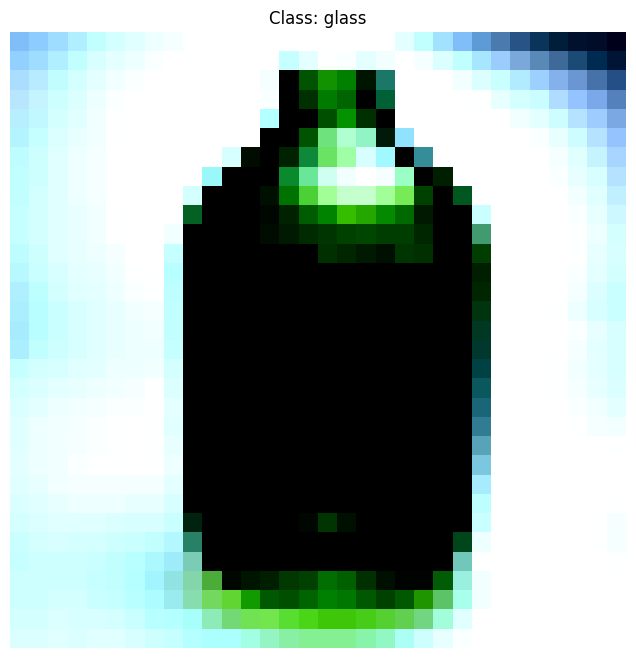

In [ ]:
# View random image from the dataset
plt.figure(figsize=(10,8))
img_display= np.transpose(images[0].numpy(), (1,2,0))
plt.imshow(img_display)
plt.title(f"Class: {class_names[labels[0].item()]}")
plt.axis('off')
plt.show()

In [ ]:
class GarbageClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    # In_channels set to 3 to match the input image channels
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1) # 8 x 32 x 32
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 8 x 16 x 16
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1,padding=1 ) # 16 x 16 x 16
    #After Pooling  : 8 x 8 x 8
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) # 32 x 8 x 8
    #After Pooling: 32 x 4 x 4
    self.fc1 = nn.Linear(32*4*4, 128)
    self.fc2 = nn.Linear(128,10)
    self.relu = nn.ReLU()

  def forward(self,x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)            # Conv1 + ReLU + Pool
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)            # Conv2 + ReLU + Pool
    x = self.conv3(x)
    x = self.relu(x)
    x = self.pool(x)            # Conv3 + ReLU + Pool
    x = x.view(-1, 32*4*4)      # Flatten
    x = self.fc1(x)
    x = self.relu(x)            # FC1 + ReLU
    x = self.fc2(x)             # Outplut layer
    return x

In [ ]:
print(f"Batch image shape: {images.shape}")

Batch image shape: torch.Size([32, 3, 32, 32])


In [ ]:
# Get the shape of the first image in the batch
channels, height, width= images[0].shape
print(f"Image size: {width} x {height} pixels")

Image size: 32 x 32 pixels


In [ ]:
model = GarbageClassifier().to(device) # Bringin model to device
criterion = nn.CrossEntropyLoss()  # Setting loss to CrossEntropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001) # Setting optimizer to Adam

In [ ]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()


/tmp/ipython-input-178857144.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_size=224
batch_size=32
# Loading train geenrator
train_datagen=ImageDataGenerator(
    rescale=1./225,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.2
                                 )
train_generator= train_datagen.flow_from_directory(
    '/content/drive/MyDrive/garbage-dataset',
    target_size=(image_size,image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
# Loading Validation Generator
validation_generator= train_datagen.flow_from_directory(
    '/content/drive/MyDrive/garbage-dataset',
    target_size=(image_size,image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 15627 images belonging to 10 classes.
Found 3902 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
# Building the MobileNetV2 model
def build_mobilenetv2_model(num_classes):
  base_model=MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))
  base_model.trainable=False

  inputs=Input(shape=(image_size,image_size,3))
  x=base_model(inputs,training=False)
  x=GlobalAveragePooling2D()(x)
  x=Dropout(0.3)(x)
  outputs=Dense(num_classes, activation='softmax')(x)
  model=Model(inputs, outputs)
  return model
# Trainign the model
mobilenet_model=build_mobilenetv2_model(num_classes=train_generator.num_classes)
mobilenet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
mobilenet_model.summary()
#Pickle this model
import pickle
with open('mobilenet_model.pkl', 'wb') as file:
  pickle.dump(mobilenet_model, file)
  print("Model saved as mobilenet_model.pkl")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model saved as mobilenet_model.pkl


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('mobilenet_best.h5', save_best_only=True)
]

history_mobilenet = mobilenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
) # Training the MobileNetV2 model over 10 epochs

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6995 - loss: 0.9610 

489/489 ━━━━━━━━━━━━━━━━━━━━ 7915s 16s/step - accuracy: 0.6997 - loss: 0.9603 - val_accuracy: 0.8821 - val_loss: 0.3682
Epoch 2/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8845 - loss: 0.3550

489/489 ━━━━━━━━━━━━━━━━━━━━ 1125s 2s/step - accuracy: 0.8845 - loss: 0.3550 - val_accuracy: 0.9018 - val_loss: 0.3170
Epoch 3/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8976 - loss: 0.3091

489/489 ━━━━━━━━━━━━━━━━━━━━ 1084s 2s/step - accuracy: 0.8976 - loss: 0.3091 - val_accuracy: 0.8993 - val_loss: 0.3068
Epoch 4/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 1068s 2s/step - accuracy: 0.9077 - loss: 0.2759 - val_accuracy: 0.9026 - val_loss: 0.3108
Epoch 5/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 1137s 2s/step - accuracy: 0.9073 - loss: 0.2807 - val_accuracy: 0.9001 - val_loss: 0.3076
Epoch 6/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9029 - loss: 0.2882

489/489 ━━━━━━━━━━━━━━━━━━━━ 1108s 2s/step - accuracy: 0.9029 - loss: 0.2882 - val_accuracy: 0.9054 - val_loss: 0.2902
Epoch 7/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9127 - loss: 0.2546

489/489 ━━━━━━━━━━━━━━━━━━━━ 1082s 2s/step - accuracy: 0.9127 - loss: 0.2546 - val_accuracy: 0.9085 - val_loss: 0.2827
Epoch 8/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 1078s 2s/step - accuracy: 0.9142 - loss: 0.2594 - val_accuracy: 0.9080 - val_loss: 0.2884
Epoch 9/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 1071s 2s/step - accuracy: 0.9127 - loss: 0.2575 - val_accuracy: 0.9049 - val_loss: 0.2870
Epoch 10/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 1083s 2s/step - accuracy: 0.9166 - loss: 0.2501 - val_accuracy: 0.8965 - val_loss: 0.3286


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
# Building the efficentnet model
def build_efficientnet_model(num_classes):
  base_model=EfficientNetB0(weights='imagenet',include_top=False, input_shape=(image_size,image_size,3))
  base_model.trainable=False
  inputs=Input(shape=(image_size,image_size,3))
  x=base_model(inputs,training=False)
  x=GlobalAveragePooling2D()(x)
  x=Dropout(0.3)(x)
  outputs=Dense(num_classes, activation='softmax')(x)
  model=Model(inputs,outputs)
  return model
# Training and optimzing this model
efficientnet_model=build_efficientnet_model(num_classes=train_generator.num_classes)
efficientnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
efficientnet_model.summary()
#Pickle this model
import pickle
with open('efficientnet_model.pkl', 'wb') as file:
  pickle.dump(efficientnet_model, file)
  print("Model saved as efficientnet_model.pkl")
  efficientnet_model.save('efficientnet_model.h5')
  print("Model saved as efficientnet_model.h5")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Model saved as efficientnet_model.pkl
Model saved as efficientnet_model.h5


In [ ]:
callbacks_eff = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('efficientnet_best.h5', save_best_only=True)
]

history_efficientnet = efficientnet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks_eff
) # Training the EfficientNetB0 model over 10 epochs


Epoch 1/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2582 - loss: 2.1611

489/489 ━━━━━━━━━━━━━━━━━━━━ 1630s 3s/step - accuracy: 0.2583 - loss: 2.1610 - val_accuracy: 0.2745 - val_loss: 2.1499
Epoch 2/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2745 - loss: 2.1470

489/489 ━━━━━━━━━━━━━━━━━━━━ 1621s 3s/step - accuracy: 0.2745 - loss: 2.1470 - val_accuracy: 0.2745 - val_loss: 2.1395
Epoch 3/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 1612s 3s/step - accuracy: 0.2672 - loss: 2.1549 - val_accuracy: 0.2745 - val_loss: 2.1531
Epoch 4/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2689 - loss: 2.1499

489/489 ━━━━━━━━━━━━━━━━━━━━ 1595s 3s/step - accuracy: 0.2689 - loss: 2.1499 - val_accuracy: 0.2745 - val_loss: 2.1281
Epoch 5/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 1678s 3s/step - accuracy: 0.2650 - loss: 2.1519 - val_accuracy: 0.2745 - val_loss: 2.1287
Epoch 6/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 1634s 3s/step - accuracy: 0.2693 - loss: 2.1435 - val_accuracy: 0.2745 - val_loss: 2.1357
Epoch 7/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 1640s 3s/step - accuracy: 0.2805 - loss: 2.1423 - val_accuracy: 0.2745 - val_loss: 2.1313


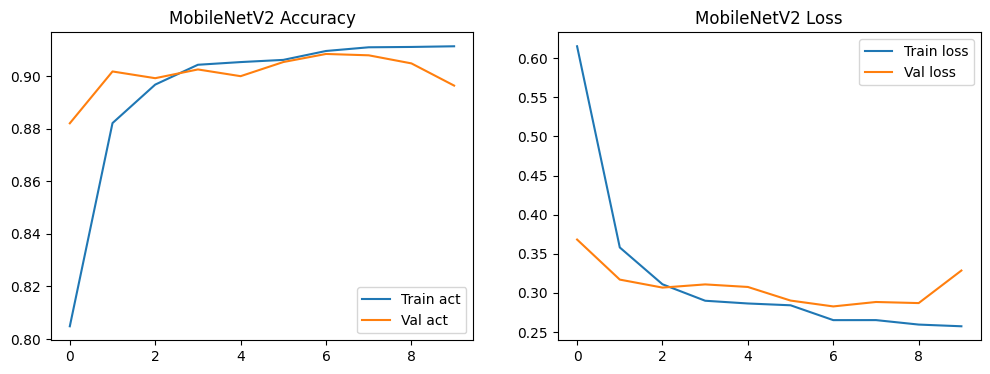

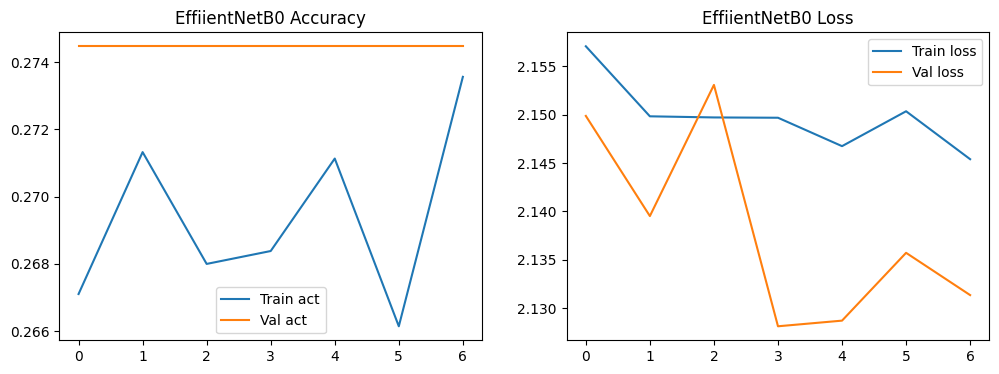

In [ ]:
def plot_history(history,title):
  plt.figure(figsize=(12,4))
  # Accuracy subplot
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'], label='Train act')
  plt.plot(history.history['val_accuracy'], label= 'Val act')
  plt.title(f'{title} Accuracy')
  plt.legend()
  # Loss subplot
  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], label='Train loss')
  plt.plot(history.history['val_loss'], label='Val loss')
  plt.title(f'{title} Loss')
  plt.legend()
  plt.show()
#Plot
plot_history(history_mobilenet, "MobileNetV2")
plot_history(history_efficientnet, "EffiientNetB0")

In [ ]:
%%writefile garbageimage.py
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from PIL import Image # Import Image from PIL
import tensorflow as tf # Import tensorflow

# Setting page configurations and assigning pages

st.set_page_config(page_title='Garbage Image Classification using Computer Vision', layout='wide')
st.sidebar.title("Navigation")

page=st.sidebar.radio('Go to', ['Introduction','Data Overview','Classification'])

if page=="Introduction":
  st.title("Garbage Image Classification using Computer Vision")
  st.markdown(""" 📌 Introduction

The management of urban waste is an increasingly pressing concern, and manual\
 methods of sorting are often labour-intensive and error-prone. This project applies computer vision and deep learning techniques to automate the \
 classification of garbage images into distinct categories. By employing models such as MobileNetV2 and EfficientNetB0, \
 the system can reliably distinguish between recyclable materials, organic waste, and residual items. The objective is to\
  demonstrate how artificial intelligence can support more efficient, accurate, and scalable waste management, ultimately promoting sustainability \
  and reducing the burden on existing recycling infrastructures.
  """)

elif page=="Data Overview":
  st.title("Data Overview")
  st.markdown("""Dataset Overview

The dataset consists of labelled images representing different waste categories, including plastics, paper, glass, metals, organic matter, and residual waste. Images vary in resolution, background, and lighting, offering a realistic reflection of everyday waste scenarios. To standardise training, all images are resized and normalised before being fed into the models. The dataset is split into training (80%) and validation (20%) sets to assess model performance objectively.\
 A notable challenge lies in class imbalance, as certain categories are more frequent than others. \
 This makes augmentation a crucial step in ensuring fair representation and balanced learning.""")

elif page=="Classification":
  st.title("Classification")


  # Load the saved Keras model
  model = tf.keras.models.load_model('mobilenet_best.h5')


  #Upload image for classification
  uploaded_file=st.file_uploader("Choose an image", type=['jpg', 'jpeg', 'png'])
  if uploaded_file is not None:
    image=Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)

  if st.button("Predict Class:"):
    if uploaded_file is not None:
      image=Image.open(uploaded_file)
      image=image.resize((224,224))
      # Convert image to numpy array and preprocess for model
      image_array = np.array(image)
      # Add batch dimension
      input_image = np.expand_dims(image_array, axis=0)
      # Normalize the image data (assuming your model expects values between 0 and 1)
      input_scaled = input_image / 255.0


      prediction=model.predict(input_scaled)[0]

      class_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash'] # Example class names

      predicted_class_index = np.argmax(prediction)
      predicted_class_name = class_names[predicted_class_index]
      st.write(f"Predicted class: {predicted_class_name}")

      # print(prediction)

Overwriting garbageimage.py


In [ ]:
!pip install streamlit

In [ ]:
!pip install pyngrok -q
from pyngrok import ngrok
from google.colab import userdata

# Terminate open tunnels if any
ngrok.kill()

# Get a ngrok authtoken from https://dashboard.ngrok.com/auth
# and paste it in the secrets tab on the left sidebar.

NGrok_Auth = userdata.get('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(NGrok_Auth)

# Open a tunnel to the port where Streamlit is running
public_url = ngrok.connect(8501)
print(f"Streamlit App URL: {public_url}")

Streamlit App URL: NgrokTunnel: "https://a65b59cfe501.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!streamlit run garbageimage.py &>/dev/null&